<a href="https://colab.research.google.com/github/efrat-dev/insider-threat-detector/blob/main/Model_With_80_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== LSTM Model with Train/Test Split ===
Loading data...
Loaded data with shape: (299880, 83)
Columns: ['employee_id', 'date', 'employee_seniority_years', 'is_malicious', 'num_print_commands', 'num_bw_prints', 'ratio_color_prints', 'first_entry_time', 'last_exit_time', 'total_presence_minutes', 'employee_department_label', 'employee_department_target', 'employee_department_freq', 'employee_campus_cat_Campus B', 'employee_campus_cat_Campus C', 'employee_campus_label', 'employee_position_label', 'employee_position_target', 'employee_position_freq', 'employee_classification_cat_1', 'employee_classification_cat_2', 'employee_classification_cat_3', 'employee_classification_label', 'employee_origin_country_label', 'employee_origin_country_target', 'employee_origin_country_freq', 'print_campuses_cat_0', 'num_exits_cat_0', 'num_exits_cat_1', 'num_exits_label', 'employee_id_log', 'employee_id_above_mean', 'employee_id_quartile', 'employee_seniority_years_log', 'employee_seniority_years_above_me

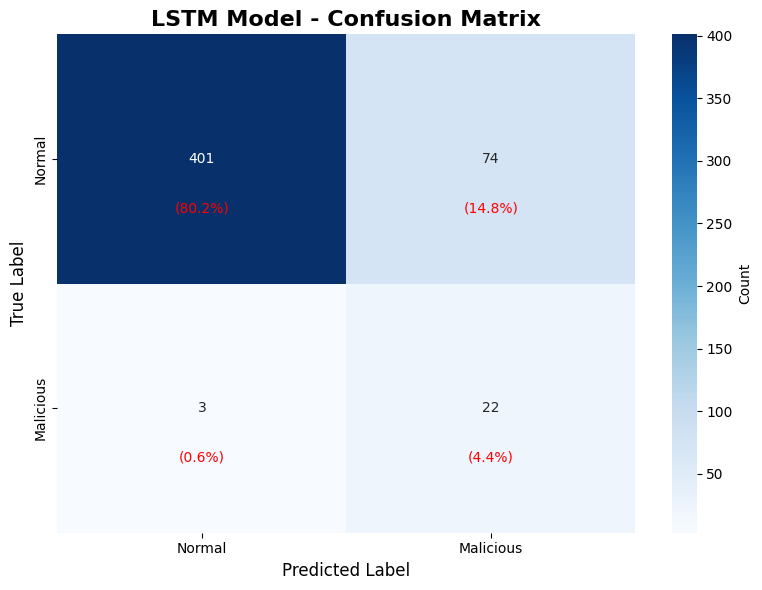


📋 Confusion Matrix Breakdown:
True Negatives (TN): 401
False Positives (FP): 74
False Negatives (FN): 3
True Positives (TP): 22

📊 Performance Analysis:
🎉 Excellent AUC - model performs very well
⚠️ Moderate F1-Score - room for improvement

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Normal       0.99      0.84      0.91       475
   Malicious       0.23      0.88      0.36        25

    accuracy                           0.85       500
   macro avg       0.61      0.86      0.64       500
weighted avg       0.95      0.85      0.88       500



In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

def load_and_preprocess_data(filepath):
    """Load and preprocess the real data"""
    print("Loading data...")

    # Try to load the CSV file
    try:
        df = pd.read_csv('/content/drive/MyDrive/processed_data1.csv')
        print(f"Loaded data with shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

    # Basic preprocessing
    print("Preprocessing data...")

    # Find feature columns (exclude employee_id, date, is_malicious)
    exclude_cols = ['employee_id', 'is_malicious']
    if 'date' in df.columns:
        exclude_cols.append('date')

    feature_cols = [col for col in df.columns if col not in exclude_cols]
    print(f"Found {len(feature_cols)} feature columns")
    print(f"Total feature count: {len(feature_cols)}")

    # Handle categorical columns
    processed_df = df.copy()
    for col in feature_cols:
        if processed_df[col].dtype == 'object':
            le = LabelEncoder()
            processed_df[col] = le.fit_transform(processed_df[col].astype(str))
        else:
            processed_df[col] = pd.to_numeric(processed_df[col], errors='coerce')
            processed_df[col].fillna(processed_df[col].mean(), inplace=True)

    return processed_df, feature_cols

class SimpleDataset(Dataset):
    def __init__(self, df, feature_cols, seq_len=180, scaler=None):
        self.seq_len = seq_len
        self.feature_cols = feature_cols
        self.samples = []
        self.labels = []

        print(f"Processing {len(df['employee_id'].unique())} employees...")

        for emp_id in df['employee_id'].unique():
            emp_df = df[df['employee_id'] == emp_id]

            # Sort by date if available
            if 'date' in emp_df.columns:
                emp_df = emp_df.sort_values('date')

            features = emp_df[feature_cols].values
            label = emp_df['is_malicious'].iloc[0]

            # Skip if no data
            if len(features) == 0:
                continue

            # Pad or truncate to seq_len
            if len(features) >= seq_len:
                features = features[-seq_len:]  # Take last seq_len days
            else:
                # Pad with last known values
                padding = np.tile(features[-1], (seq_len - len(features), 1))
                features = np.vstack([features, padding])

            if scaler:
                features = scaler.transform(features)

            self.samples.append(torch.tensor(features, dtype=torch.float32))
            self.labels.append(torch.tensor(label, dtype=torch.float32))

        print(f"Created {len(self.samples)} samples")
        pos_samples = sum(self.labels)
        print(f"Positive samples: {pos_samples}, Negative samples: {len(self.labels) - pos_samples}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]

class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(SimpleLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=0.2)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=0.2)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        lstm_out1, _ = self.lstm1(x)
        lstm_out1 = self.bn1(lstm_out1[:, -1, :])
        lstm_out1 = lstm_out1.unsqueeze(1).repeat(1, x.size(1), 1)

        lstm_out2, _ = self.lstm2(lstm_out1)
        out = self.bn2(lstm_out2[:, -1, :])
        out = self.dropout(out)
        return self.fc(out).squeeze()

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """Plot a beautiful confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Malicious'],
                yticklabels=['Normal', 'Malicious'],
                cbar_kws={'label': 'Count'})

    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)

    # Add percentage annotations
    total = cm.sum()
    for i in range(2):
        for j in range(2):
            percentage = cm[i, j] / total * 100
            plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)',
                    ha='center', va='center', fontsize=10, color='red')

    plt.tight_layout()
    plt.show()

    return cm

def calculate_metrics(y_true, y_pred, y_probs):
    """Calculate and display all metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    if len(set(y_true)) > 1:
        auc = roc_auc_score(y_true, y_probs)
    else:
        auc = 0.0

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }

def main():
    print("=== LSTM Model with Train/Test Split ===")
    print("=" * 60)

    # Load your real data
    df, feature_cols = load_and_preprocess_data('processed_data.csv')

    if df is None:
        print("Failed to load data!")
        return None, None

    # Use all features
    print(f"\n🎯 Using ALL {len(feature_cols)} features for training")

    # Check class distribution
    total_employees = len(df['employee_id'].unique())
    malicious_employees = df.groupby('employee_id')['is_malicious'].first().sum()
    normal_employees = total_employees - malicious_employees

    print(f"Total employees: {total_employees}")
    print(f"Malicious employees: {malicious_employees}")
    print(f"Normal employees: {normal_employees}")

    # Split employees
    employee_ids = df['employee_id'].unique()
    employee_labels = df.groupby('employee_id')['is_malicious'].first()

    train_ids, test_ids = train_test_split(
        employee_ids, test_size=0.3,
        stratify=employee_labels, random_state=42
    )

    train_df = df[df['employee_id'].isin(train_ids)]
    test_df = df[df['employee_id'].isin(test_ids)]

    print(f"\nTrain employees: {len(train_ids)}, Test employees: {len(test_ids)}")

    # Fit scaler on training data
    scaler = StandardScaler()
    scaler.fit(train_df[feature_cols])

    # Create datasets
    train_dataset = SimpleDataset(train_df, feature_cols, seq_len=180, scaler=scaler)
    test_dataset = SimpleDataset(test_df, feature_cols, seq_len=180, scaler=scaler)

    if len(train_dataset) == 0:
        print("No training samples found!")
        return None, None

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

    # Calculate class weights
    train_labels = [label.item() for _, label in train_dataset]
    pos_count = sum(train_labels)
    neg_count = len(train_labels) - pos_count
    pos_weight = neg_count / pos_count if pos_count > 0 else 1.0

    print(f"Class balance - Positive: {pos_count}, Negative: {neg_count}")
    print(f"Using pos_weight: {pos_weight:.2f}")

    # Initialize model
    model = SimpleLSTM(input_dim=len(feature_cols))
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training with early stopping
    print("\n" + "="*50)
    print("TRAINING")
    print("="*50)

    model.train()
    best_loss = float('inf')
    patience = 3
    patience_counter = 0

    for epoch in range(15):
        total_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")

        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Evaluation
    print("\n" + "="*50)
    print("EVALUATION")
    print("="*50)

    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            probs = torch.sigmoid(outputs)

            all_probs.extend(probs.numpy())
            all_labels.extend(batch_y.numpy())

    # Find optimal threshold
    from sklearn.metrics import roc_curve
    if len(set(all_labels)) > 1:
        fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
    else:
        optimal_threshold = 0.5

    # Apply optimal threshold
    all_preds = [1 if prob > optimal_threshold else 0 for prob in all_probs]

    print(f"Optimal threshold: {optimal_threshold:.4f}")

    # Calculate metrics
    metrics = calculate_metrics(all_labels, all_preds, all_probs)

    print(f"\n📊 FINAL RESULTS:")
    print(f"🎯 AUC Score: {metrics['auc']:.4f}")
    print(f"📈 Accuracy: {metrics['accuracy']:.4f}")
    print(f"🎯 Precision: {metrics['precision']:.4f}")
    print(f"🔍 Recall: {metrics['recall']:.4f}")
    print(f"⚖️ F1-Score: {metrics['f1']:.4f}")

    # Plot confusion matrix
    print("\n" + "="*50)
    print("CONFUSION MATRIX")
    print("="*50)

    cm = plot_confusion_matrix(all_labels, all_preds,
                              title="LSTM Model - Confusion Matrix")

    # Print detailed confusion matrix breakdown
    tn, fp, fn, tp = cm.ravel()
    print(f"\n📋 Confusion Matrix Breakdown:")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")

    print(f"\n📊 Performance Analysis:")
    if metrics['auc'] < 0.6:
        print("❌ Poor AUC - model performance is close to random")
    elif metrics['auc'] < 0.7:
        print("⚠️ Fair AUC - model has some predictive power")
    elif metrics['auc'] < 0.8:
        print("✅ Good AUC - model performs well")
    else:
        print("🎉 Excellent AUC - model performs very well")

    if metrics['f1'] < 0.3:
        print("❌ Low F1-Score - model struggles with imbalanced data")
    elif metrics['f1'] < 0.5:
        print("⚠️ Moderate F1-Score - room for improvement")
    else:
        print("✅ Good F1-Score - balanced precision and recall")

    print("\n" + "="*50)
    print("DETAILED CLASSIFICATION REPORT")
    print("="*50)
    print(classification_report(all_labels, all_preds,
                              target_names=['Normal', 'Malicious']))

    return model, metrics

if __name__ == "__main__":
    model, metrics = main()